# Minigraph Mtb SV Pan-Genome Evaluation
## Part 2: Sequence content analysis

This notebook contains the code to parsed in processed node info from the SV Mtb pan-genome graph.


### Import Statements

In [2]:
import numpy as np
import pandas as pd
import scipy.stats

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# https://bioframe.readthedocs.io/en/latest/guide-intervalops.html
import bioframe as bf


In [4]:
import time

In [5]:
import ast

#### Pandas Viewing Settings

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import/parse processed H37rv genome annotations

In [7]:
RepoRef_Dir = "../../References"

AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir = f"{RepoRef_Dir}/201027_H37rv_AnnotatedGenes_And_IntergenicRegions"
H37Rv_GenomeAnnotations_Genes_TSV = f"{AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir}/H37Rv_GenomeAnnotations.Genes.tsv"

## H37Rv Gene Annotations TSV
H37Rv_GenomeAnno_Genes_DF = pd.read_csv(H37Rv_GenomeAnnotations_Genes_TSV, sep = "\t")
H37Rv_GeneInfo_Subset_DF = H37Rv_GenomeAnno_Genes_DF[["H37rv_GeneID", "Symbol", "Feature", "Functional_Category", "Is_Pseudogene", "Product", "PEandPPE_Subfamily", "ExcludedGroup_Category"]]

RvID_To_Symbol_Dict = dict(H37Rv_GeneInfo_Subset_DF[['H37rv_GeneID', 'Symbol']].values)
Symbol_To_FuncCat_Dict = dict(H37Rv_GeneInfo_Subset_DF[['Symbol', 'Functional_Category']].values)


In [8]:
H37Rv_GenomeAnno_Genes_DF.head(3)

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,Feature,Functional_Category,Is_Pseudogene,Product,PEandPPE_Subfamily,ExcludedGroup_Category
0,NC_000962.3,0,1524,+,Rv0001,dnaA,CDS,information pathways,No,Chromosomal replication initiator protein DnaA,None,NotExcluded
1,NC_000962.3,2051,3260,+,Rv0002,dnaN,CDS,information pathways,No,DNA polymerase III (beta chain) DnaN (DNA nucl...,None,NotExcluded
2,NC_000962.3,3279,4437,+,Rv0003,recF,CDS,information pathways,No,DNA replication and repair protein RecF (singl...,None,NotExcluded


# Parse sample metadata & preprocessed genome info/results

In [9]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"
MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"

## Parse sample Metadata (N = 151)

In [10]:
WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [11]:
WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"
MtbWGA_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir

### Define PATHS relevant to Minigraph analysis

In [12]:
target_OutputDir = MtbWGA_SMK_Pipeline_OutputDir
Minigraph_151CI_OutDir = f"{target_OutputDir}/Minigraph"

MG_WGA151CI_GFA = f"{Minigraph_151CI_OutDir}/Minigraph_H37rv_Vs_151CI.V1.gfa"
MG_WGA151CI_Bubble_SV_BED = f"{Minigraph_151CI_OutDir}/Minigraph_H37rv_Vs_151CI.V1.Bubble.SV.bed"
MG_WGA151CI_Stable_FA = f"{Minigraph_151CI_OutDir}/Minigraph_H37rv_Vs_151CI.V1.Stable.fa"

MG_WGA151CI_MergedSVInfo_TSV = f"{Minigraph_151CI_OutDir}/Minigraph_H37rv_Vs_151CI.MergedSV.Info.tsv"
MG_WGA151CI_MergedSVInfo_SVVCF = f"{Minigraph_151CI_OutDir}/Minigraph_H37rv_Vs_151CI.MergedSV.Info.svvcf"


In [13]:
Minigraph_151CI_OutDir

'/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/Minigraph'

#### use `gfatools` to print general stats of the SV graph (rGFA format)

In [14]:
!gfatools stat $MG_WGA151CI_GFA

Number of segments: 3138
Number of links: 4705
Number of arcs: 9410
Max rank: 129
Total segment length: 5196363
Average segment length: 1655.947
Sum of rank-0 segment lengths: 4411532
Max degree: 8
Average degree: 1.499
[M::main] Version: 0.5-r292-dirty
[M::main] CMD: gfatools stat /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/Minigraph/Minigraph_H37rv_Vs_151CI.V1.gfa
[M::main] Real time: 0.036 sec; CPU: 0.037 sec


### Define paths to processed analysis of SV Pan-genome graph (minigraph)

In [15]:
PangenomeAnalysis_Dir = "../../Data/MtbPangenomeAnalysis_SetV5"

MG_Node_KmerComp_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.Minigraph.NodeKmerComp.Summary.V1.tsv.gz" 

MG_AvA_Node_KmerAnalysis_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.Minigraph.NodeKmerComp.AllVsAll.V1.tsv.gz"     

MG_BubbleSumm_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.Minigraph.BubbleSummary.BED.tsv.gz"     

MG_SVVCF_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.Minigraph.BubbleAlleleInfo.SVVCF.tsv.gz" 

MG_SVInfo_TSV_GZ = f"{PangenomeAnalysis_Dir}/MtbSVPG.Minigraph.BubbleAlleleInfo.SVInfo.tsv.gz" 


### Parse in `AvA_Nodes_DF`

In [16]:
AvA_Nodes_DF = pd.read_csv(MG_AvA_Node_KmerAnalysis_TSV_GZ, sep = "\t" )
AvA_Nodes_DF.shape

(123104, 6)

In [17]:
AvA_Nodes_DF.head()

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,JaccardSim,JaccardContain
0,s3,s2959,56,61,0.781250,0.961538
1,s7,s2247,1876,42,0.006501,0.006501
2,s8,s2823,542,87,0.096339,0.097656
3,s13,s2037,24063,49,0.000208,0.000208
4,s13,s2039,24063,114,0.000208,0.000208


### Parse in `MG_Nodes_KmerVsRefSets_DF`

In [18]:
MG_Nodes_KmerComp_DF = pd.read_csv(MG_Node_KmerComp_TSV_GZ, sep = "\t" )
MG_Nodes_KmerComp_DF.shape

(3138, 18)

In [19]:
MG_Nodes_KmerComp_DF.head()

,NodeID,IsSVNode,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,Jaccard_Cont_WiRv_PEPPEs,Jaccard_Cont_WiRv_InfoPathways,Jaccard_Cont_WiRv_ConservedHypo,Jaccard_Cont_WiRv_CellWallCellProc,Jaccard_Cont_WiRv_StableRNAs,Jaccard_Cont_WiRv_InterMetabolism,Jaccard_Cont_WiRv_RegProteins,Jaccard_Cont_WiRv_VirulenceDetoxAdaptation,Jaccard_Cont_WiRv_LipidMetabolism,Jaccard_Cont_WiRv_Unknown,BubbleID,MaxJC_ToOtherNode
0,s1,False,1533,1.0,0.0,0.0,0.0,0.994012,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,None,0.000000
1,s2,False,58,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,None,0.000000
2,s3,True,56,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,BubbleRegion_2,0.961538
3,s4,True,5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,BubbleRegion_2,0.000000
4,s5,False,11970,1.0,0.0,0.0,0.0,0.612312,0.044724,0.141457,0.007286,0.0,0.0,0.0,0.0,0.0,None,0.000000


### Parse in `MG_SV_BED_DF`

In [20]:
MG_SV_BED_DF = pd.read_csv(MG_BubbleSumm_TSV_GZ, sep = "\t" )

# Convert the string representation of the list of nodes to python list of nodes
MG_SV_BED_DF["NodePath_Trimmed"] = MG_SV_BED_DF["NodePath_Trimmed"].apply(ast.literal_eval)

MG_SV_BED_DF.shape

(535, 14)

In [21]:
MG_SV_BED_DF.head(3)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
0,NC_000962.3,1533,1533,0,0,"s1,s2",[],s1,s2,1,BubbleRegion_1,0,NaN,NaN
1,NC_000962.3,1591,1652,61,1480,"s2,s2034,s2959,s2035,s3,s2036,s2036,s3,s2035,s...","[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",s2,s5,2,BubbleRegion_2,11,NaN,NaN
2,NC_000962.3,13622,13622,0,1358,"s5,s2744,s6",[s2744],s5,s6,3,BubbleRegion_3,1,NaN,NaN


### Parse in `MG_SVVCF_DF`

In [22]:
MG_SVVCF_DF = pd.read_csv(MG_SVVCF_TSV_GZ, sep = "\t" )
MG_SVVCF_DF.shape

(535, 169)

### Parse in `MG_SVInfo_DF`

In [23]:
MG_SVInfo_DF = pd.read_csv(MG_SVInfo_TSV_GZ, sep = "\t" )
MG_SVInfo_DF.shape

(535, 160)

In [24]:
MG_SV_BED_DF["NodePath_Trimmed"].values[:2]

array([list([]),
       list(['s2034', 's2959', 's2035', 's3', 's2036', 's2036', 's3', 's2035', 's2959', 's2034', 's4'])],
      dtype=object)

In [25]:
MG_SV_BED_DF.head(4)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
0,NC_000962.3,1533,1533,0,0,"s1,s2",[],s1,s2,1,BubbleRegion_1,0,NaN,NaN
1,NC_000962.3,1591,1652,61,1480,"s2,s2034,s2959,s2035,s3,s2036,s2036,s3,s2035,s...","[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",s2,s5,2,BubbleRegion_2,11,NaN,NaN
2,NC_000962.3,13622,13622,0,1358,"s5,s2744,s6",[s2744],s5,s6,3,BubbleRegion_3,1,NaN,NaN
3,NC_000962.3,26469,28345,42,1876,"s6,s2247,s7,s8","[s2247, s7]",s6,s8,4,BubbleRegion_4,2,"Rv0021c,whiB5,Rv0023","Rv0021c,Rv0022c,Rv0023"


### Create Dict of SV Node ID to BubbleID mappings

In [26]:
NodeID_ToBubbleID_Dict = {}

for i, row in MG_SV_BED_DF.iterrows():
    
    i_BubbleID =  row["BubbleID"]
    i_NodePath_Trimmed = row["NodePath_Trimmed"]

    # Map all SV nodes to their Bubble Region ID
    for NodeID in i_NodePath_Trimmed:
        NodeID_ToBubbleID_Dict[NodeID] = i_BubbleID
        

In [27]:
list(NodeID_ToBubbleID_Dict.items())[:10]

[('s2034', 'BubbleRegion_2'),
 ('s2959', 'BubbleRegion_2'),
 ('s2035', 'BubbleRegion_2'),
 ('s3', 'BubbleRegion_2'),
 ('s2036', 'BubbleRegion_2'),
 ('s4', 'BubbleRegion_2'),
 ('s2744', 'BubbleRegion_3'),
 ('s2247', 'BubbleRegion_4'),
 ('s7', 'BubbleRegion_4'),
 ('s2823', 'BubbleRegion_5')]

## Create dictionary of BubbleID to overlapping H37Rv gene annotations

In [28]:
BubbleID_To_OvrLapGenes_Dict = MG_SV_BED_DF.set_index("BubbleID")["Overlap_Genes"].to_dict()

#### Peak at the genes overlapping the first 10 bubble regions

In [29]:
list(BubbleID_To_OvrLapGenes_Dict.items())[:10]

[('BubbleRegion_1', nan),
 ('BubbleRegion_2', nan),
 ('BubbleRegion_3', nan),
 ('BubbleRegion_4', 'Rv0021c,whiB5,Rv0023'),
 ('BubbleRegion_5', 'Rv0024'),
 ('BubbleRegion_6', 'bioF2'),
 ('BubbleRegion_7', nan),
 ('BubbleRegion_8', nan),
 ('BubbleRegion_9', nan),
 ('BubbleRegion_10', 'Rv0063')]

## Part 1: Look at high level stats of the SV Pan-genome graph of 151 Mtb genomes

### How many total nodes are there? 

In [30]:
MG_Nodes_KmerComp_DF.shape

(3138, 18)

### What is the cumlative lenth of the graph?

In [31]:
MG_Nodes_KmerComp_DF["SeqLength"].sum()

5196363

### How many total bubbles are there identified by Minigraph? (535)

In [32]:
MG_SV_BED_DF.shape[0]

535

## How many nodes have length less than 31 bp?
#### Nodes w/ length < 31 bp will be excluded from out k-mer based analysis of node sequence content

Take aways:
- 627 TOTAL nodes have length < 31 bp
- 577 SV Nodes have length < 31 bp
- 50 Core Nodes have length < 31 bp


In [33]:
MG_Nodes_KmerComp_DF.query("SeqLength < 31").shape[0]

627

In [34]:
MG_Nodes_KmerComp_DF.query("IsSVNode == False & SeqLength < 31").shape[0]

50

In [35]:
MG_Nodes_KmerComp_DF.query("IsSVNode == True & SeqLength < 31").shape[0]

577

In [36]:
MG_Nodes_KmerComp_DF["SeqLength"].describe()

count     3138.000000
mean      1655.947419
std       5107.483405
min          1.000000
25%         45.250000
50%        133.000000
75%       1305.250000
max      73572.000000
Name: SeqLength, dtype: float64

### Filter for CORE-Nodes w/ at least 31 bp of length (N = 2061)

In [37]:
MG_CoreNodes_All_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == False")
MG_CoreNodes_All_DF.shape  

(536, 18)

In [38]:
MG_CoreNodes_PASS_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == False").query("SeqLength >= 31")     
MG_CoreNodes_PASS_DF.shape

(486, 18)

In [39]:
MG_CoreNodes_Sub31bp_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == False").query("SeqLength < 31")     
MG_CoreNodes_Sub31bp_DF.shape

(50, 18)

In [40]:
MG_CoreNodes_Sub31bp_DF["SeqLength"].sum()

659

### SV Nodes basic breakdown

| Category            | Total Length (bp) | Number of Nodes |
|---------------------|-------------------|-----------------|
| All SV Nodes        | 1,283,223         | 2,602           |
| "PASS" SV Nodes     | 1,276,550         | 2,025           |
| Non-"PASS" SV Nodes (Len < 31 bp) | 6,673             | 577             |


In [41]:
MG_SVNodes_All_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True")
MG_SVNodes_All_DF.shape

(2602, 18)

In [42]:
MG_SVNodes_PASS_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True").query("SeqLength >= 31")     
MG_SVNodes_PASS_DF.shape

(2025, 18)

In [43]:
MG_SVNodes_Sub31bp_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True").query("SeqLength < 31")     
MG_SVNodes_Sub31bp_DF.shape

(577, 18)

### What is the total length of ALL SV nodes?

In [44]:
MG_Nodes_KmerComp_DF.query("IsSVNode == True")["SeqLength"].sum()

1283223

### What is the total length of PASS SV nodes (Len >= 31 bp?)

In [45]:
MG_SVNodes_PASS_DF["SeqLength"].sum()

1276550

### What is the total length of sub 31bp SV nodes? (filtered out for k-mer analysis)

In [46]:
MG_SVNodes_Sub31bp_DF["SeqLength"].sum()

6673

## Part 2: Plot distribution of SV node lengths & # of SV nodes per bubble region

### Look at distribution of # of SV nodes per bubble region

In [47]:
MG_SV_BED_DF.head(10).tail(4)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
6,NC_000962.3,38999,38999,0,56,"s10,s2662,s11",[s2662],s10,s11,7,BubbleRegion_7,1,NaN,NaN
7,NC_000962.3,39022,39029,7,287,"s11,s12,s2037,s2038,s2133,s2928,s2134,s2135,s2...","[s12, s2037, s2038, s2133, s2928, s2134, s2135...",s11,s13,8,BubbleRegion_8,8,NaN,NaN
8,NC_000962.3,63092,63092,0,1358,"s13,s2824,s14",[s2824],s13,s14,9,BubbleRegion_9,1,NaN,NaN
9,NC_000962.3,68269,68269,0,1358,"s14,s3018,s15",[s3018],s14,s15,10,BubbleRegion_10,1,Rv0063,Rv0063


In [48]:
MG_SV_BED_DF["NumSVNodes"].describe() 

count    535.000000
mean       4.971963
std       15.103549
min        0.000000
25%        1.000000
50%        1.000000
75%        3.500000
max      224.000000
Name: NumSVNodes, dtype: float64

In [49]:
!mkdir Results2_Plots/

mkdir: cannot create directory ‘Results2_Plots/’: File exists


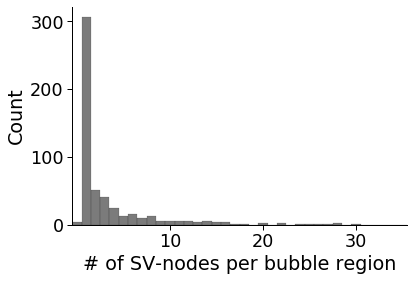

In [50]:
plt.figure(figsize =(6,4) ) 
sns.set_context("paper", font_scale=2)

sns.histplot(MG_SV_BED_DF["NumSVNodes"].values, bins = np.arange(0, 250, 1), color = '#4F4F4F' ) 
sns.despine()

#plt.title("Distr. of SV nodes per SV bubble")
plt.ylabel("Count")
plt.xlabel("# of SV-nodes per bubble region")
plt.xlim(0,36)


# Get current x-axis tick locations
current_ticks = plt.xticks()[0]

# Shift ticks by half a count to the right
shifted_ticks = current_ticks + 0.5

# Set new ticks
plt.xticks([10.5, 20.5, 30.5], [10, 20, 30] )

plt.savefig("Results2_Plots/2.B.SVNodesPerBubble.Histo.png", dpi = 300)
plt.savefig("Results2_Plots/2.B.SVNodesPerBubble.Histo.svg")

plt.show()

### Look at length distribution of of SV nodes

In [51]:
MG_SVNodes_PASS_DF["SeqLength"].describe()

count     2025.000000
mean       630.395062
std       1476.309335
min         31.000000
25%         71.000000
50%        174.000000
75%        932.000000
max      37214.000000
Name: SeqLength, dtype: float64

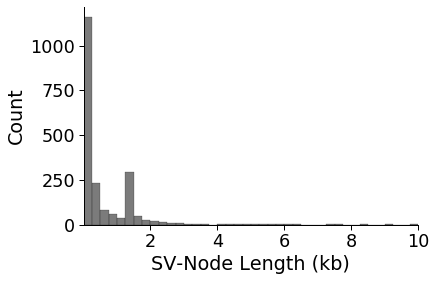

In [52]:
plt.figure(figsize =(6,4) ) 
sns.set_context("paper", font_scale=2)

sns.histplot(MG_SVNodes_PASS_DF["SeqLength"].values, bins = np.arange(0, 40000, 250), color = '#4F4F4F' )  
sns.despine()

plt.xlim(0, 10000)
plt.xlabel("SV-Node Length (kb)")


x_tick_loc = [2000, 4000, 6000, 8000, 10000]
#x_tick_label = ["2 kb", "4 kb", "6 kb", "8 kb", "10 kb"]
x_tick_label = [2, 4, 6, 8, 10]

#x_tick_loc = np.arange(0, 11000, 1000)
#x_tick_label = np.arange(0, 11, 1)


plt.xticks(x_tick_loc, x_tick_label )

plt.savefig("Results2_Plots/2.C.SVNodeLen.Histo.png", dpi = 300)
plt.savefig("Results2_Plots/2.C.SVNodeLen.Histo.svg")

plt.show()

In [53]:
MG_SVNodes_PASS_DF.head(4)

,NodeID,IsSVNode,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,Jaccard_Cont_WiRv_PEPPEs,Jaccard_Cont_WiRv_InfoPathways,Jaccard_Cont_WiRv_ConservedHypo,Jaccard_Cont_WiRv_CellWallCellProc,Jaccard_Cont_WiRv_StableRNAs,Jaccard_Cont_WiRv_InterMetabolism,Jaccard_Cont_WiRv_RegProteins,Jaccard_Cont_WiRv_VirulenceDetoxAdaptation,Jaccard_Cont_WiRv_LipidMetabolism,Jaccard_Cont_WiRv_Unknown,BubbleID,MaxJC_ToOtherNode
2,s3,True,56,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,BubbleRegion_2,0.961538
6,s7,True,1876,1.0,0.0,0.0,0.0,0.000000,0.206934,0.0,0.0,0.000000,0.601842,0.0,0.0,0.0,BubbleRegion_4,0.006501
15,s16,True,904,1.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,BubbleRegion_11,0.000000
17,s18,True,732,1.0,0.0,0.0,0.0,0.040698,0.000000,0.0,0.0,0.059593,0.000000,0.0,0.0,0.0,BubbleRegion_12,0.000000


## Part 3: Summary of node classifications within the SV pan-genome graph

- Question 1: How many Core Nodes are there? What is there cumulative length?
  
- Question 2: How many SV Nodes are there? What is there cumulative length?
  
    - Question 3: How many SV nodes are too small to be evaluated using k-mer (31-mer) based comparison? (length < 31bp)

    - Question 4: How many SV nodes are long enough to be evaluated using k-mer (31-mer) based comparison? ("PASS" SV Nodes)
  
    - Question 5: How many SV nodes have "unique sequence content within the graph"?

        - Question 6: Of nodes that are are classified as "unique sequence content within the graph", how much is also "unique relative to H37Rv"?
  
    - Question 7: How many SV nodes have "non-unique sequence content within the graph"?
        - Question 8: Of nodes that are are classified as "non-unique sequence content within the graph", how much is "unique relative to H37Rv"?
          
        - Question 9: Of the nodes that are classified as "non-unique sequence content within the graph", how many have k-mer overlap w/ sequences annotated as related to "phages & insertion sequences"?
  
            - Question 10: Of the nodes that are classified as i) "non-unique sequence" & ii) "phages & insertion sequences", how many share k-mer content with the IS6110 element specifically?


#### Preparation - Breakdown core and SV nodes

In [54]:
MG_CoreNodes_All_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == False")

MG_SVNodes_All_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True")
MG_SVNodes_PASS_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True").query("SeqLength >= 31")     
MG_SVNodes_Sub31bp_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True").query("SeqLength < 31")     


#### Question 1: How many Core Nodes are there? What is there cumulative length?

In [55]:
MG_CoreNodes_All_DF.shape[0] 

536

In [56]:
MG_CoreNodes_All_DF["SeqLength"].sum()

3913140

#### Question 2: How many SV Nodes are there? What is there cumulative length?

In [57]:
MG_SVNodes_All_DF.shape[0]

2602

In [58]:
MG_SVNodes_All_DF["SeqLength"].sum()

1283223

#### Question 3: How many SV nodes are too small to be evaluated using k-mer (31-mer) based comparison? (Filtered out for downstream evaluation)

Basically, how many have length < 31bp?

In [59]:
MG_SVNodes_Sub31bp_DF.shape[0]

577

In [60]:
MG_SVNodes_Sub31bp_DF["SeqLength"].sum() 

6673

#### Question 4: How many SV nodes are long enough to be evaluated using k-mer (31-mer) based comparison? ("PASS" SV Nodes)

Basically, how many SV nodes have length >= 31bp?

In [61]:
MG_SVNodes_PASS_DF.shape[0]

2025

In [62]:
MG_SVNodes_PASS_DF["SeqLength"].sum() 

1276550

#### Question 5: How many SV nodes have "unique sequence content within the graph"?

In [63]:
MG_SVNodes_UnqSeq_DF =  MG_SVNodes_PASS_DF.query("MaxJC_ToOtherNode < 0.05")

In [64]:
MG_SVNodes_UnqSeq_DF.shape[0]

463

In [65]:
MG_SVNodes_UnqSeq_DF["SeqLength"].sum()

301511

In [66]:
301511 / 1283223 # len of unique SV nodes / total len of SV nodes

0.2349638371506745

In [67]:
302 / 1300 # 302 kb / 1,300 kb

0.2323076923076923

#### Question 6: Of "unique sequence content within the graph" nodes, how much is **also** "unique relative to H37Rv"?

In [68]:
MG_SVNodes_UnqSeq_UnqToRv_DF = MG_SVNodes_UnqSeq_DF.query("Jaccard_Cont_WiRv < 0.05")

In [69]:
MG_SVNodes_UnqSeq_UnqToRv_DF.shape[0]

76

In [70]:
MG_SVNodes_UnqSeq_UnqToRv_DF["SeqLength"].sum()  

51806

#### Question 7: How many SV nodes have "non-unique sequence content within the graph"?

In [71]:
MG_SVNodes_NoUnqSeq_DF = MG_SVNodes_PASS_DF.query("MaxJC_ToOtherNode >= 0.05")

In [72]:
MG_SVNodes_NoUnqSeq_DF.shape[0]

1562

In [73]:
MG_SVNodes_NoUnqSeq_DF["SeqLength"].sum()  

975039

#### Question 8: Of "non-unique sequence content within the graph" nodes, how much is **also** "unique relative to H37Rv"?

In [74]:
MG_SVNodes_NoUnqSeq_UnqToRv_DF = MG_SVNodes_NoUnqSeq_DF.query("Jaccard_Cont_WiRv < 0.05")

In [75]:
MG_SVNodes_NoUnqSeq_UnqToRv_DF.shape[0]

84

In [76]:
MG_SVNodes_NoUnqSeq_UnqToRv_DF["SeqLength"].sum()  

14815

#### Question 9: Of "non-unique sequence content within the graph" nodes, how many have k-mer overlap w/ sequences annotated as related to "phages & insertion sequences"?

In [77]:
MG_SVNodes_NoUnqSeq_ISandPhages_DF = MG_SVNodes_NoUnqSeq_DF.query("Jaccard_Cont_WiRv_InsSeqAndPhages > 0.5")

In [78]:
MG_SVNodes_NoUnqSeq_ISandPhages_DF.shape[0] 

339

In [79]:
MG_SVNodes_NoUnqSeq_ISandPhages_DF["SeqLength"].sum() 

489105

#### - Question 10: Of the nodes that are classified as i) "non-unique sequence" & ii) "phages & insertion sequences", how many share k-mer content with the IS6110 element specifically?

In [80]:
MG_SVNodes_NoUnqSeq_ISandPhages_IS6110_DF = MG_SVNodes_NoUnqSeq_ISandPhages_DF.query("Jaccard_Cont_WiIS6110 > 0.5")

In [81]:
MG_SVNodes_NoUnqSeq_ISandPhages_IS6110_DF.shape[0]

322

In [82]:
MG_SVNodes_NoUnqSeq_ISandPhages_IS6110_DF["SeqLength"].sum()  

455214

#### Question 11: How many SV nodes (& total length) are unique to H37Rv? (Independent of whether it is unique within the graph)

In [83]:
MG_SVNodes_UnqToRv_All_DF = MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05 & SeqLength >= 31")

In [84]:
MG_SVNodes_UnqToRv_All_DF.shape[0]

160

In [85]:
MG_SVNodes_UnqToRv_All_DF["SeqLength"].sum()  

66621

In [86]:
14815 + 51806

66621

In [87]:
15 + 52

67

In [88]:
66621 / 1283223 # len of "unique to H37Rv" SV nodes / total len of SV nodes

0.05191693104004526

In [89]:
67/ 1300 # 67 kb / 1,300 kb

0.05153846153846154

In [90]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05").shape

(160, 18)

# Analyze abundance of each gene category in UNIQUE and REDUDANT SV Nodes

In [91]:
listOf_JC_Cols = ["Jaccard_Cont_WiRv_InsSeqAndPhages",
                  "Jaccard_Cont_WiRv_PEPPEs",
                  "Jaccard_Cont_WiRv_InfoPathways",
                  "Jaccard_Cont_WiRv_ConservedHypo", 
                  "Jaccard_Cont_WiRv_CellWallCellProc",
                  "Jaccard_Cont_WiRv_StableRNAs",
                  "Jaccard_Cont_WiRv_InterMetabolism",
                  "Jaccard_Cont_WiRv_RegProteins",
                  "Jaccard_Cont_WiRv_VirulenceDetoxAdaptation",
                  "Jaccard_Cont_WiRv_LipidMetabolism",
                  "Jaccard_Cont_WiRv_Unknown"]

In [92]:
for col in listOf_JC_Cols:

    i_SV_NoUnq_InCat =  MG_SVNodes_NoUnqSeq_DF.query(f"{col} > 0.5")
    i_SV_Unq_InCat =  MG_SVNodes_UnqSeq_DF.query(f"{col} > 0.5")
    i_SV_PASS_InCat =  MG_SVNodes_PASS_DF.query(f"{col} > 0.5")

    print(col, "i_SV_NoUnq_InCat", i_SV_NoUnq_InCat.shape[0], i_SV_NoUnq_InCat["SeqLength"].sum(), i_SV_NoUnq_InCat["SeqLength"].sum() / MG_SVNodes_NoUnqSeq_DF["SeqLength"].sum()  )
    #print(col, "i_SV_Unq_InCat", i_SV_Unq_InCat.shape[0], i_SV_Unq_InCat["SeqLength"].sum(), i_SV_Unq_InCat["SeqLength"].sum() / MG_SVNodes_PASS_DF["SeqLength"].sum() )
    #print(col, "ALL SV Nodes", i_SV_PASS_InCat.shape[0], i_SV_PASS_InCat["SeqLength"].sum(), i_SV_PASS_InCat["SeqLength"].sum() / MG_SVNodes_PASS_DF["SeqLength"].sum() )
    #print()

Jaccard_Cont_WiRv_InsSeqAndPhages i_SV_NoUnq_InCat 339 489105 0.5016260888026017
Jaccard_Cont_WiRv_PEPPEs i_SV_NoUnq_InCat 462 121321 0.1244268177990829
Jaccard_Cont_WiRv_InfoPathways i_SV_NoUnq_InCat 2 114 0.00011691840018706944
Jaccard_Cont_WiRv_ConservedHypo i_SV_NoUnq_InCat 84 43076 0.04417874567068599
Jaccard_Cont_WiRv_CellWallCellProc i_SV_NoUnq_InCat 36 14249 0.014613774423382039
Jaccard_Cont_WiRv_StableRNAs i_SV_NoUnq_InCat 0 0 0.0
Jaccard_Cont_WiRv_InterMetabolism i_SV_NoUnq_InCat 62 28275 0.028998840046398144
Jaccard_Cont_WiRv_RegProteins i_SV_NoUnq_InCat 14 6151 0.006308465610093545
Jaccard_Cont_WiRv_VirulenceDetoxAdaptation i_SV_NoUnq_InCat 2 857 0.0008789392014063027
Jaccard_Cont_WiRv_LipidMetabolism i_SV_NoUnq_InCat 15 26130 0.026798928042878284
Jaccard_Cont_WiRv_Unknown i_SV_NoUnq_InCat 4 1178 0.001208156801933051


In [93]:
for col in listOf_JC_Cols:

    i_Core_InCat =  MG_CoreNodes_All_DF.query(f"{col} > 0.5")

    print(col, "i_Core_InCat", i_Core_InCat.shape[0], i_Core_InCat["SeqLength"].sum(), i_Core_InCat["SeqLength"].sum() / MG_CoreNodes_All_DF["SeqLength"].sum()  )
    #print(col, "i_SV_Unq_InCat", i_SV_Unq_InCat.shape[0], i_SV_Unq_InCat["SeqLength"].sum(), i_SV_Unq_InCat["SeqLength"].sum() / MG_SVNodes_PASS_DF["SeqLength"].sum() )
    #print(col, "ALL SV Nodes", i_SV_PASS_InCat.shape[0], i_SV_PASS_InCat["SeqLength"].sum(), i_SV_PASS_InCat["SeqLength"].sum() / MG_SVNodes_PASS_DF["SeqLength"].sum() )
    #print()

Jaccard_Cont_WiRv_InsSeqAndPhages i_Core_InCat 1 485 0.00012394138722355958
Jaccard_Cont_WiRv_PEPPEs i_Core_InCat 75 60807 0.015539183366810285
Jaccard_Cont_WiRv_InfoPathways i_Core_InCat 17 84786 0.021666998880694278
Jaccard_Cont_WiRv_ConservedHypo i_Core_InCat 42 80887 0.02067061234711766
Jaccard_Cont_WiRv_CellWallCellProc i_Core_InCat 30 173618 0.04436795003501025
Jaccard_Cont_WiRv_StableRNAs i_Core_InCat 0 0 0.0
Jaccard_Cont_WiRv_InterMetabolism i_Core_InCat 56 340268 0.08695523288203336
Jaccard_Cont_WiRv_RegProteins i_Core_InCat 7 27669 0.0070707922537910734
Jaccard_Cont_WiRv_VirulenceDetoxAdaptation i_Core_InCat 4 18761 0.004794359516909694
Jaccard_Cont_WiRv_LipidMetabolism i_Core_InCat 19 166834 0.042634303909392456
Jaccard_Cont_WiRv_Unknown i_Core_InCat 0 0 0.0


In [94]:
MG_SVNodes_NoUnqSeq_DF.head()

,NodeID,IsSVNode,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,Jaccard_Cont_WiRv_PEPPEs,Jaccard_Cont_WiRv_InfoPathways,Jaccard_Cont_WiRv_ConservedHypo,Jaccard_Cont_WiRv_CellWallCellProc,Jaccard_Cont_WiRv_StableRNAs,Jaccard_Cont_WiRv_InterMetabolism,Jaccard_Cont_WiRv_RegProteins,Jaccard_Cont_WiRv_VirulenceDetoxAdaptation,Jaccard_Cont_WiRv_LipidMetabolism,Jaccard_Cont_WiRv_Unknown,BubbleID,MaxJC_ToOtherNode
2,s3,True,56,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,BubbleRegion_2,0.961538
19,s20,True,234,1.0,0.0,0.0,0.000000,0.0,0.485294,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,BubbleRegion_12,1.000000
41,s42,True,53,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,BubbleRegion_18,0.478261
46,s47,True,6416,1.0,0.0,0.0,0.097401,0.0,0.042123,0.0,0.0,0.510648,0.0,0.0,0.197776,0.0,BubbleRegion_19,0.883808
47,s48,True,351,1.0,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,BubbleRegion_19,0.180685


In [95]:
MG_SVNodes_UnqSeq_DF.head()

,NodeID,IsSVNode,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,Jaccard_Cont_WiRv_PEPPEs,Jaccard_Cont_WiRv_InfoPathways,Jaccard_Cont_WiRv_ConservedHypo,Jaccard_Cont_WiRv_CellWallCellProc,Jaccard_Cont_WiRv_StableRNAs,Jaccard_Cont_WiRv_InterMetabolism,Jaccard_Cont_WiRv_RegProteins,Jaccard_Cont_WiRv_VirulenceDetoxAdaptation,Jaccard_Cont_WiRv_LipidMetabolism,Jaccard_Cont_WiRv_Unknown,BubbleID,MaxJC_ToOtherNode
6,s7,True,1876,1.0,0.0,0.0,0.0,0.000000,0.206934,0.000000,0.0,0.000000,0.601842,0.0,0.0,0.0,BubbleRegion_4,0.006501
15,s16,True,904,1.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,BubbleRegion_11,0.000000
17,s18,True,732,1.0,0.0,0.0,0.0,0.040698,0.000000,0.000000,0.0,0.059593,0.000000,0.0,0.0,0.0,BubbleRegion_12,0.000000
18,s19,True,687,1.0,0.0,0.0,0.0,0.922374,0.045662,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,BubbleRegion_12,0.045662
20,s21,True,2557,1.0,0.0,0.0,0.0,0.000000,0.103285,0.784725,0.0,0.000000,0.000000,0.0,0.0,0.0,BubbleRegion_12,0.003166


In [96]:
MG_SVNodes_PASS_DF.head()

,NodeID,IsSVNode,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,Jaccard_Cont_WiRv_PEPPEs,Jaccard_Cont_WiRv_InfoPathways,Jaccard_Cont_WiRv_ConservedHypo,Jaccard_Cont_WiRv_CellWallCellProc,Jaccard_Cont_WiRv_StableRNAs,Jaccard_Cont_WiRv_InterMetabolism,Jaccard_Cont_WiRv_RegProteins,Jaccard_Cont_WiRv_VirulenceDetoxAdaptation,Jaccard_Cont_WiRv_LipidMetabolism,Jaccard_Cont_WiRv_Unknown,BubbleID,MaxJC_ToOtherNode
2,s3,True,56,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,BubbleRegion_2,0.961538
6,s7,True,1876,1.0,0.0,0.0,0.0,0.000000,0.206934,0.0,0.0,0.000000,0.601842,0.0,0.0,0.0,BubbleRegion_4,0.006501
15,s16,True,904,1.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,BubbleRegion_11,0.000000
17,s18,True,732,1.0,0.0,0.0,0.0,0.040698,0.000000,0.0,0.0,0.059593,0.000000,0.0,0.0,0.0,BubbleRegion_12,0.000000
18,s19,True,687,1.0,0.0,0.0,0.0,0.922374,0.045662,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,BubbleRegion_12,0.045662


# Classify Nodes based on match

### Define functions

In [97]:
# Define the Jaccard index columns corresponding to gene categories
listOf_JC_Cols = [
    "Jaccard_Cont_WiRv_InsSeqAndPhages",
    "Jaccard_Cont_WiRv_PEPPEs",
    "Jaccard_Cont_WiRv_InfoPathways",
    "Jaccard_Cont_WiRv_ConservedHypo",
    "Jaccard_Cont_WiRv_CellWallCellProc",
    "Jaccard_Cont_WiRv_StableRNAs",
    "Jaccard_Cont_WiRv_InterMetabolism",
    "Jaccard_Cont_WiRv_RegProteins",
    "Jaccard_Cont_WiRv_VirulenceDetoxAdaptation",
    "Jaccard_Cont_WiRv_LipidMetabolism",
    "Jaccard_Cont_WiRv_Unknown"
]

listOf_JC_Cols = [
    "Jaccard_Cont_WiRv_InsSeqAndPhages",
    "Jaccard_Cont_WiRv_PEPPEs",
    "Jaccard_Cont_WiRv_InfoPathways",
    "Jaccard_Cont_WiRv_ConservedHypo",
    "Jaccard_Cont_WiRv_CellWallCellProc",
    "Jaccard_Cont_WiRv_StableRNAs",
    "Jaccard_Cont_WiRv_InterMetabolism",
    "Jaccard_Cont_WiRv_RegProteins",
    "Jaccard_Cont_WiRv_VirulenceDetoxAdaptation",
    "Jaccard_Cont_WiRv_LipidMetabolism",
]

JC_Cols_ToCategoryName = {
    "Jaccard_Cont_WiRv_PEPPEs": "PE/PPE",
    "Jaccard_Cont_WiRv_CellWallCellProc": "cell wall and cell processes",
    "Jaccard_Cont_WiRv_ConservedHypo": "conserved hypotheticals",
    "Jaccard_Cont_WiRv_InfoPathways": "information pathways",
    "Jaccard_Cont_WiRv_InsSeqAndPhages": "insertion seqs and phages",
    "Jaccard_Cont_WiRv_StableRNAs": "stable RNAs",
    "Jaccard_Cont_WiRv_InterMetabolism": "intermediary metabolism and respiration",
    "Jaccard_Cont_WiRv_RegProteins": "regulatory proteins",
    "Jaccard_Cont_WiRv_VirulenceDetoxAdaptation": "virulence, detoxification, adaptation",
    "Jaccard_Cont_WiRv_LipidMetabolism": "lipid metabolism",
    "Jaccard_Cont_WiRv_Unknown": "unknown"
}


In [98]:
# Define function to classify a node based on a threshold
def classify_node(row, threshold=0.25):
    filtered_matches = {col: row[col] for col in listOf_JC_Cols if row[col] >= threshold}
    if filtered_matches:
        max_value = max(filtered_matches.values())
        strongest_categories = [
            col for col, value in filtered_matches.items() if value == max_value
        ]
        return strongest_categories
    return None  # No valid matches



# Define function to summarize node categories
def summarize_sv_categories(sv_nodes_df, listOf_JC_Cols):
    category_summary = {}
    for col in listOf_JC_Cols:
        total_length = sv_nodes_df.loc[
            sv_nodes_df["Strongest_Match"].apply(
                lambda matches: col in matches if matches else False
            ),
            "SeqLength"
        ].sum()
        node_count = sv_nodes_df["Strongest_Match"].apply(
            lambda matches: col in matches if matches else False
        ).sum()
        category_summary[col] = {"Total Length": total_length, "Node Count": node_count}

    # Add "NoMatch" to the summary
    no_match_length = sv_nodes_df.loc[
        sv_nodes_df["Strongest_Match"].isnull(), "SeqLength"
    ].sum()
    no_match_count = sv_nodes_df["Strongest_Match"].isnull().sum()

    category_summary["NoMatch"] = {
        "Total Length": no_match_length,
        "Node Count": no_match_count,
    }

    # Convert to DataFrame
    summary_df = pd.DataFrame.from_dict(category_summary, orient="index")
    summary_df["Relative Size (%)"] = (
        summary_df["Total Length"] / summary_df["Total Length"].sum() * 100
    ).round(1)

    return summary_df


# Update the summarize_sv_categories function to include "Functional_Category"
def summarize_sv_categories_with_functional_category(sv_nodes_df, listOf_JC_Cols):
    category_summary = {}
    category_mapping = {
        "Jaccard_Cont_WiRv_PEPPEs": "PE/PPE",
        "Jaccard_Cont_WiRv_CellWallCellProc": "cell wall and cell processes",
        "Jaccard_Cont_WiRv_ConservedHypo": "conserved hypotheticals",
        "Jaccard_Cont_WiRv_InfoPathways": "information pathways",
        "Jaccard_Cont_WiRv_InsSeqAndPhages": "insertion seqs and phages",
        "Jaccard_Cont_WiRv_StableRNAs": "stable RNAs",
        "Jaccard_Cont_WiRv_InterMetabolism": "intermediary metabolism and respiration",
        "Jaccard_Cont_WiRv_RegProteins": "regulatory proteins",
        "Jaccard_Cont_WiRv_VirulenceDetoxAdaptation": "virulence, detoxification, adaptation",
        "Jaccard_Cont_WiRv_LipidMetabolism": "lipid metabolism",
        "Jaccard_Cont_WiRv_Unknown": "unknown",
    }

    for col in listOf_JC_Cols:
        total_length = sv_nodes_df.loc[
            sv_nodes_df["Strongest_Match"].apply(
                lambda matches: col in matches if matches else False
            ),
            "SeqLength"
        ].sum()
        node_count = sv_nodes_df["Strongest_Match"].apply(
            lambda matches: col in matches if matches else False
        ).sum()
        category_summary[col] = {
            "Functional_Category": category_mapping.get(col, "unknown"),
            "Total Length": total_length,
            "Node Count": node_count,
        }

    # Add "NoMatch" to the summary
    no_match_length = sv_nodes_df.loc[
        sv_nodes_df["Strongest_Match"].isnull(), "SeqLength"
    ].sum()
    no_match_count = sv_nodes_df["Strongest_Match"].isnull().sum()

    category_summary["NoMatch"] = {
        "Functional_Category": "NoMatch",
        "Total Length": no_match_length,
        "Node Count": no_match_count,
    }

    # Convert to DataFrame
    summary_df = pd.DataFrame.from_dict(category_summary, orient="index")
    summary_df["Relative Size (%)"] = (
        summary_df["Total Length"] / summary_df["Total Length"].sum() * 100
    ).round(2)

    return summary_df


###  Step 1: Look at relative size of gene categories in H73R

In [99]:
# Correctly reference "Start" and "End" columns to calculate gene lengths
H37Rv_GeneInfo_Subset_DF = H37Rv_GenomeAnno_Genes_DF[
    ["Functional_Category", "Start", "End"]
].copy()
H37Rv_GeneInfo_Subset_DF["Gene_Length"] = (
    H37Rv_GeneInfo_Subset_DF["End"] - H37Rv_GeneInfo_Subset_DF["Start"] + 1
)

# Group by functional category and calculate total length and relative fractions
gene_cat_lengths = (
    H37Rv_GeneInfo_Subset_DF.groupby("Functional_Category")["Gene_Length"]
    .sum()
    .reset_index()
)

gene_cat_lengths["Relative_Fraction"] = (
    gene_cat_lengths["Gene_Length"] / gene_cat_lengths["Gene_Length"].sum()
)

gene_cat_lengths["Percent_RefGeneLengths"] = (gene_cat_lengths["Relative_Fraction"] * 100).round(2)


Gene_Cat_RefPerc = gene_cat_lengths[["Functional_Category", "Percent_RefGeneLengths"]]

In [100]:
Gene_Cat_RefPerc

,Functional_Category,Percent_RefGeneLengths
0,PE/PPE,7.01
1,cell wall and cell processes,20.00
2,conserved hypotheticals,18.77
3,information pathways,6.76
4,insertion seqs and phages,2.69
5,intermediary metabolism and respiration,25.75
6,lipid metabolism,10.53
7,regulatory proteins,4.18
8,stable RNAs,0.20
9,unknown,0.21


### Step 2: Classify nodes

In [101]:
# Apply classification to the main DataFrame
threshold = 0.5  # Set the classification threshold
MG_Nodes_KmerComp_DF["Strongest_Match"] = MG_Nodes_KmerComp_DF.apply(
    lambda row: classify_node(row, threshold), axis=1
)

In [102]:
# Filter SV Nodes based on the queries provided
MG_SVNodes_PASS_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True and SeqLength >= 31")

MG_SVNodes_UnqSeq_DF = MG_SVNodes_PASS_DF.query("MaxJC_ToOtherNode < 0.05")
MG_SVNodes_UnqSeq_UnqToRv_DF = MG_SVNodes_UnqSeq_DF.query("Jaccard_Cont_WiRv < 0.05")
MG_SVNodes_NoUnqSeq_DF = MG_SVNodes_PASS_DF.query("MaxJC_ToOtherNode >= 0.05")


In [103]:
Gene_Cat_RefPerc

,Functional_Category,Percent_RefGeneLengths
0,PE/PPE,7.01
1,cell wall and cell processes,20.00
2,conserved hypotheticals,18.77
3,information pathways,6.76
4,insertion seqs and phages,2.69
5,intermediary metabolism and respiration,25.75
6,lipid metabolism,10.53
7,regulatory proteins,4.18
8,stable RNAs,0.20
9,unknown,0.21


In [109]:
# Summarize UNIQUE SV nodes
All_SV_nodes_summary = summarize_sv_categories_with_functional_category(MG_SVNodes_PASS_DF, listOf_JC_Cols)
All_SV_nodes_summary = pd.merge(All_SV_nodes_summary, Gene_Cat_RefPerc, how = "left", on = "Functional_Category")

# Summarize UNIQUE SV nodes
unique_nodes_summary = summarize_sv_categories_with_functional_category(MG_SVNodes_UnqSeq_DF, listOf_JC_Cols)
unique_nodes_summary = pd.merge(unique_nodes_summary, Gene_Cat_RefPerc, how = "left", on = "Functional_Category")

# Summarize NON-UNIQUE SV nodes
nonunique_nodes_summary = summarize_sv_categories_with_functional_category(MG_SVNodes_NoUnqSeq_DF, listOf_JC_Cols)
nonunique_nodes_summary = pd.merge(nonunique_nodes_summary, Gene_Cat_RefPerc, how = "left", on = "Functional_Category")


In [110]:
All_SV_nodes_summary

,Functional_Category,Total Length,Node Count,Relative Size (%),Percent_RefGeneLengths
0,insertion seqs and phages,503748,346,39.46,2.69
1,PE/PPE,167166,647,13.10,7.01
2,information pathways,4363,10,0.34,6.76
3,conserved hypotheticals,66735,111,5.23,18.77
4,cell wall and cell processes,42715,73,3.35,20.00
5,stable RNAs,0,0,0.00,0.20
6,intermediary metabolism and respiration,69088,105,5.41,25.75
7,regulatory proteins,13000,21,1.02,4.18
8,"virulence, detoxification, adaptation",10554,7,0.83,3.91
9,lipid metabolism,51437,39,4.03,10.53


In [114]:
nonunique_nodes_summary.sort_values("Total Length", ascending=False)

,Functional_Category,Total Length,Node Count,Relative Size (%),Percent_RefGeneLengths
0,insertion seqs and phages,489105,339,50.16,2.69
10,NoMatch,245761,546,25.21,NaN
1,PE/PPE,121321,462,12.44,7.01
3,conserved hypotheticals,43076,84,4.42,18.77
6,intermediary metabolism and respiration,28275,62,2.90,25.75
9,lipid metabolism,26130,15,2.68,10.53
4,cell wall and cell processes,14249,36,1.46,20.00
7,regulatory proteins,6151,14,0.63,4.18
8,"virulence, detoxification, adaptation",857,2,0.09,3.91
2,information pathways,114,2,0.01,6.76


In [112]:
unique_nodes_summary

,Functional_Category,Total Length,Node Count,Relative Size (%),Percent_RefGeneLengths
0,insertion seqs and phages,14643,7,4.86,2.69
1,PE/PPE,45845,185,15.21,7.01
2,information pathways,4249,8,1.41,6.76
3,conserved hypotheticals,23659,27,7.85,18.77
4,cell wall and cell processes,28466,37,9.44,20.00
5,stable RNAs,0,0,0.00,0.20
6,intermediary metabolism and respiration,40813,43,13.54,25.75
7,regulatory proteins,6849,7,2.27,4.18
8,"virulence, detoxification, adaptation",9697,5,3.22,3.91
9,lipid metabolism,25307,24,8.39,10.53


In [445]:
nonunique_nodes_summary

,Functional_Category,Total Length,Node Count,Relative Size (%),Percent_RefGeneLengths
0,insertion seqs and phages,489105,339,50.16,2.69
1,PE/PPE,121321,462,12.44,7.01
2,information pathways,114,2,0.01,6.76
3,conserved hypotheticals,43076,84,4.42,18.77
4,cell wall and cell processes,14249,36,1.46,20.00
5,stable RNAs,0,0,0.00,0.20
6,intermediary metabolism and respiration,28275,62,2.90,25.75
7,regulatory proteins,6151,14,0.63,4.18
8,"virulence, detoxification, adaptation",857,2,0.09,3.91
9,lipid metabolism,26130,15,2.68,10.53


# Test - Extras

In [170]:
# Correctly reference "Start" and "End" columns to calculate gene lengths
H37Rv_GeneInfo_Subset_DF = H37Rv_GenomeAnno_Genes_DF[
    ["Functional_Category", "Start", "End"]
].copy()
H37Rv_GeneInfo_Subset_DF["Gene_Length"] = (
    H37Rv_GeneInfo_Subset_DF["End"] - H37Rv_GeneInfo_Subset_DF["Start"] + 1
)

# Group by functional category and calculate total length and relative fractions
gene_cat_lengths = (
    H37Rv_GeneInfo_Subset_DF.groupby("Functional_Category")["Gene_Length"]
    .sum()
    .reset_index()
)

gene_cat_lengths["Relative_Fraction"] = (
    gene_cat_lengths["Gene_Length"] / gene_cat_lengths["Gene_Length"].sum()
)

gene_cat_lengths["Percent_RefGeneLengths"] = (gene_cat_lengths["Relative_Fraction"] * 100).round(2)


In [171]:
gene_cat_lengths

,Functional_Category,Gene_Length,Relative_Fraction,Percent_RefGeneLengths
0,PE/PPE,283512,0.070067,7.01
1,cell wall and cell processes,809458,0.200049,20.00
2,conserved hypotheticals,759298,0.187653,18.77
3,information pathways,273332,0.067551,6.76
4,insertion seqs and phages,108810,0.026891,2.69
5,intermediary metabolism and respiration,1042048,0.257531,25.75
6,lipid metabolism,425978,0.105276,10.53
7,regulatory proteins,169206,0.041818,4.18
8,stable RNAs,8223,0.002032,0.20
9,unknown,8403,0.002077,0.21


In [179]:
# Define the Jaccard index columns corresponding to gene categories
listOf_JC_Cols = [
    "Jaccard_Cont_WiRv_InsSeqAndPhages",
    "Jaccard_Cont_WiRv_PEPPEs",
    "Jaccard_Cont_WiRv_InfoPathways",
    "Jaccard_Cont_WiRv_ConservedHypo",
    "Jaccard_Cont_WiRv_CellWallCellProc",
    "Jaccard_Cont_WiRv_StableRNAs",
    "Jaccard_Cont_WiRv_InterMetabolism",
    "Jaccard_Cont_WiRv_RegProteins",
    "Jaccard_Cont_WiRv_VirulenceDetoxAdaptation",
    "Jaccard_Cont_WiRv_LipidMetabolism",
    "Jaccard_Cont_WiRv_Unknown"
]

JC_Cols_ToCategoryName = {
    "Jaccard_Cont_WiRv_PEPPEs": "PE/PPE",
    "Jaccard_Cont_WiRv_CellWallCellProc": "cell wall and cell processes",
    "Jaccard_Cont_WiRv_ConservedHypo": "conserved hypotheticals",
    "Jaccard_Cont_WiRv_InfoPathways": "information pathways",
    "Jaccard_Cont_WiRv_InsSeqAndPhages": "insertion seqs and phages",
    "Jaccard_Cont_WiRv_StableRNAs": "stable RNAs",
    "Jaccard_Cont_WiRv_InterMetabolism": "intermediary metabolism and respiration",
    "Jaccard_Cont_WiRv_RegProteins": "regulatory proteins",
    "Jaccard_Cont_WiRv_VirulenceDetoxAdaptation": "virulence, detoxification, adaptation",
    "Jaccard_Cont_WiRv_LipidMetabolism": "lipid metabolism",
    "Jaccard_Cont_WiRv_Unknown": "unknown"
}


# Filter SV Nodes based on the queries provided
MG_SVNodes_PASS_DF = MG_Nodes_KmerComp_DF.query("IsSVNode == True and SeqLength >= 31")

MG_SVNodes_UnqSeq_DF = MG_SVNodes_PASS_DF.query("MaxJC_ToOtherNode < 0.05")
MG_SVNodes_UnqSeq_UnqToRv_DF = MG_SVNodes_UnqSeq_DF.query("Jaccard_Cont_WiRv < 0.05")
MG_SVNodes_NoUnqSeq_DF = MG_SVNodes_PASS_DF.query("MaxJC_ToOtherNode >= 0.05")

# Compute the fraction of SV nodes in each category
analysis_results = []

for col in listOf_JC_Cols:
    # Nodes with redundant sequence content in category
    i_SV_NoUnq_InCat = MG_SVNodes_NoUnqSeq_DF.query(f"{col} > 0.5")
    # Nodes with unique sequence content in category
    i_SV_Unq_InCat = MG_SVNodes_UnqSeq_DF.query(f"{col} > 0.5")
    # All SV nodes in category
    i_SV_PASS_InCat = MG_SVNodes_PASS_DF.query(f"{col} > 0.5")

    analysis_results.append({
        "Category": col,
        "SV_NoUnq_Count": i_SV_NoUnq_InCat.shape[0],
        "SV_NoUnq_Length": i_SV_NoUnq_InCat["SeqLength"].sum(),
        "SV_NoUnq_Fraction_Length": i_SV_NoUnq_InCat["SeqLength"].sum() / MG_SVNodes_NoUnqSeq_DF["SeqLength"].sum(),
        "SV_Unq_Count": i_SV_Unq_InCat.shape[0],
        "SV_Unq_Length": i_SV_Unq_InCat["SeqLength"].sum(),
        "SV_Unq_Fraction_Length": i_SV_Unq_InCat["SeqLength"].sum() / MG_SVNodes_UnqSeq_DF["SeqLength"].sum(),
        "SV_PASS_Count": i_SV_PASS_InCat.shape[0],
        "SV_PASS_Length": i_SV_PASS_InCat["SeqLength"].sum(),
        "SV_PASS_Fraction_Length": i_SV_PASS_InCat["SeqLength"].sum() / MG_SVNodes_PASS_DF["SeqLength"].sum()
    })

# Convert the results to a DataFrame
analysis_results_DF = pd.DataFrame(analysis_results)

# Update the DataFrame to display fractions as percentages with 2 decimal places
analysis_results_DF.update(
    analysis_results_DF.filter(like='_Fraction_Length').applymap(lambda x: round(x * 100, 2))
)

# Add a "Functional_Category" column to adjusted_analysis_results_DF
analysis_results_DF["Functional_Category"] = analysis_results_DF["Category"].map(JC_Cols_ToCategoryName)

# Sort adjusted_analysis_results_DF to match the order in gene_cat_lengths
analysis_results_DF = analysis_results_DF.set_index("Functional_Category").reindex(
    gene_cat_lengths["Functional_Category"]
).reset_index()

# Retry the merge operation
merged_results_DF = pd.merge(
    gene_cat_lengths,
    analysis_results_DF,
    on="Functional_Category",
    how="inner"
)

In [180]:
merged_results_DF

,Functional_Category,Gene_Length,Relative_Fraction,Percent_RefGeneLengths,Category,SV_NoUnq_Count,SV_NoUnq_Length,SV_NoUnq_Fraction_Length,SV_Unq_Count,SV_Unq_Length,SV_Unq_Fraction_Length,SV_PASS_Count,SV_PASS_Length,SV_PASS_Fraction_Length
0,PE/PPE,283512,0.070067,7.01,Jaccard_Cont_WiRv_PEPPEs,462,121321,12.44,185,45845,15.21,647,167166,13.10
1,cell wall and cell processes,809458,0.200049,20.00,Jaccard_Cont_WiRv_CellWallCellProc,36,14249,1.46,37,28466,9.44,73,42715,3.35
2,conserved hypotheticals,759298,0.187653,18.77,Jaccard_Cont_WiRv_ConservedHypo,84,43076,4.42,27,23659,7.85,111,66735,5.23
3,information pathways,273332,0.067551,6.76,Jaccard_Cont_WiRv_InfoPathways,2,114,0.01,8,4249,1.41,10,4363,0.34
4,insertion seqs and phages,108810,0.026891,2.69,Jaccard_Cont_WiRv_InsSeqAndPhages,339,489105,50.16,7,14643,4.86,346,503748,39.46
5,intermediary metabolism and respiration,1042048,0.257531,25.75,Jaccard_Cont_WiRv_InterMetabolism,62,28275,2.90,42,40748,13.51,104,69023,5.41
6,lipid metabolism,425978,0.105276,10.53,Jaccard_Cont_WiRv_LipidMetabolism,15,26130,2.68,24,25307,8.39,39,51437,4.03
7,regulatory proteins,169206,0.041818,4.18,Jaccard_Cont_WiRv_RegProteins,14,6151,0.63,7,6849,2.27,21,13000,1.02
8,stable RNAs,8223,0.002032,0.20,Jaccard_Cont_WiRv_StableRNAs,0,0,0.00,0,0,0.00,0,0,0.00
9,unknown,8403,0.002077,0.21,Jaccard_Cont_WiRv_Unknown,4,1178,0.12,0,0,0.00,4,1178,0.09


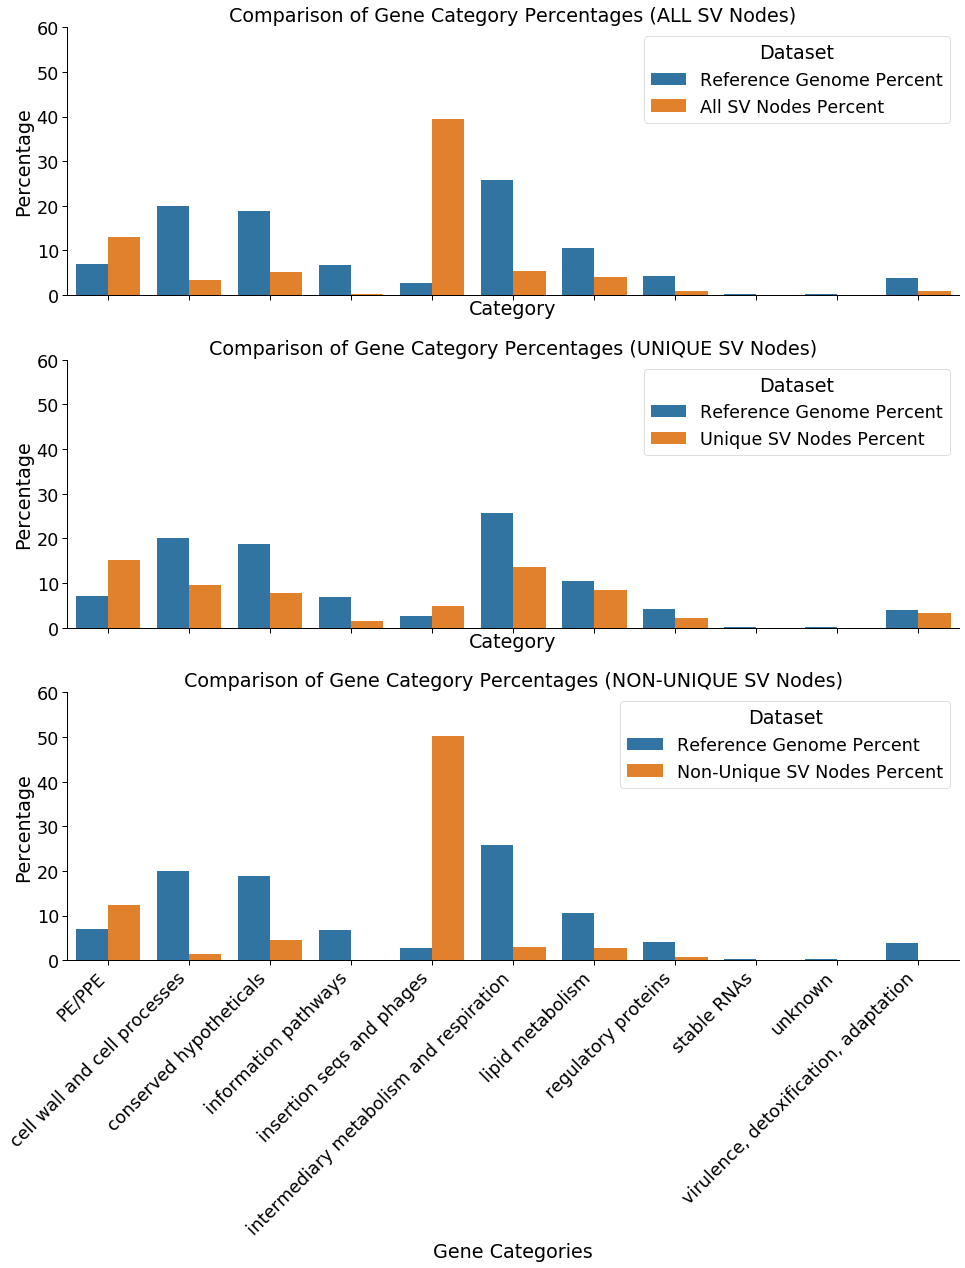

In [190]:
# Create a shared x-axis for all three plots using subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Prepare data for ALL SV nodes
comparison_all_sv_df = pd.DataFrame({
    "Category": gene_cat_lengths["Functional_Category"],
    "Reference Genome Percent": gene_cat_lengths["Percent_RefGeneLengths"],
    "All SV Nodes Percent": merged_results_DF["SV_PASS_Fraction_Length"] 
})
comparison_all_sv_melted = comparison_all_sv_df.melt(
    id_vars="Category",
    value_vars=["Reference Genome Percent", "All SV Nodes Percent"],
    var_name="Dataset",
    value_name="Percentage"
)
sns.barplot(ax=axes[0], data=comparison_all_sv_melted, x="Category", y="Percentage", hue="Dataset")
axes[0].set_title("Comparison of Gene Category Percentages (ALL SV Nodes)")
axes[0].set_ylabel("Percentage")
axes[0].set_ylim(0, 60)
sns.despine(ax=axes[0])

# Prepare data for UNIQUE SV nodes
comparison_unique_sv_df = pd.DataFrame({
    "Category": gene_cat_lengths["Functional_Category"],
    "Reference Genome Percent": gene_cat_lengths["Percent_RefGeneLengths"],
    "Unique SV Nodes Percent": merged_results_DF["SV_Unq_Fraction_Length"] 
})
comparison_unique_sv_melted = comparison_unique_sv_df.melt(
    id_vars="Category",
    value_vars=["Reference Genome Percent", "Unique SV Nodes Percent"],
    var_name="Dataset",
    value_name="Percentage"
)
sns.barplot(ax=axes[1], data=comparison_unique_sv_melted, x="Category", y="Percentage", hue="Dataset")
axes[1].set_title("Comparison of Gene Category Percentages (UNIQUE SV Nodes)")
axes[1].set_ylabel("Percentage")
axes[1].set_ylim(0, 60)
sns.despine(ax=axes[1])

# Prepare data for NON-UNIQUE SV nodes
comparison_nonunique_sv_df = pd.DataFrame({
    "Category": gene_cat_lengths["Functional_Category"],
    "Reference Genome Percent": gene_cat_lengths["Percent_RefGeneLengths"],
    "Non-Unique SV Nodes Percent": merged_results_DF["SV_NoUnq_Fraction_Length"] 
})
comparison_nonunique_sv_melted = comparison_nonunique_sv_df.melt(
    id_vars="Category",
    value_vars=["Reference Genome Percent", "Non-Unique SV Nodes Percent"],
    var_name="Dataset",
    value_name="Percentage"
)
sns.barplot(ax=axes[2], data=comparison_nonunique_sv_melted, x="Category", y="Percentage", hue="Dataset")
axes[2].set_title("Comparison of Gene Category Percentages (NON-UNIQUE SV Nodes)")
axes[2].set_ylabel("Percentage")
axes[2].set_xlabel("Gene Categories")
axes[2].set_ylim(0, 60)
sns.despine(ax=axes[2])

# Adjust layout and show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
